In [3]:
# Major version: the feature setup
# Minor version: model hypertunning
VERSION = 'v1.1'
major_VERSION = VERSION.split('.')[0]+'.0'

# Model Details
## Features:
- One hot encoded **day of week** and **month** (not year)
- Weather feature (OHE):
    - Icons (cloudy, partial cloudy, ...)
    - Precipitates Type (None, Snow, Sleet, Rain)
- Station info:
    - community area (OHE)
    - capacity
    - long, lat
    
## Target
- Log scale/normal scale
    
# Work Flow
## Training Preprocessing
- Merge station community area (Join tables)
- Drop id after merging
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Pipeline
- OHE on date time (Remember column indices)
- Scaling for `year, lon_ave, lat_ave, dp_max, temp_high, temp_low` (`MinMaxScaler`)
- Regressor()

## Test Preprocessing
- Start with Pandas template (station_id, lon_ave, lat_ave, dp_max, OHE community area)
- Add weather info (temp_high/low, and OHE ICONs and Precipitates Types)
- Convert to numpy matrix

## Post prediction
- Rescale if trained on log
- Hard cap negative (activation function)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Load data

In [5]:
INFO_verbose = False

In [6]:
%%time
st_template = pd.read_pickle('../data/model_v1.0_template.pk')

CPU times: user 3.86 ms, sys: 388 µs, total: 4.25 ms
Wall time: 2.69 ms


In [7]:
if INFO_verbose:
    st_template.info()

In [8]:
%%time
## load preprocessed data

if os.path.exists('../data/divvy_data_model_'+major_VERSION+'.pk'):
    print("Loading from previous pickle file.")
    data = pd.read_pickle('../data/divvy_data_model_'+major_VERSION+'.pk')
else:
    print("Create data set for this model... ")
    data_lst = []

    for year in [2013, 2014, 2015, 2016, 2017, 2018]:
        dt_tmp = pd.read_feather('../data/Final_Divvy_data_'+str(year)+'.feather')
        data_lst.append(dt_tmp)

    data = pd.concat(data_lst, ignore_index=True)


    data.to_pickle('../data/divvy_data_model_'+major_VERSION+'.pk')
    print("Data saved to pickle file")

Loading from previous pickle file.
CPU times: user 138 ms, sys: 370 ms, total: 507 ms
Wall time: 505 ms


In [9]:
if INFO_verbose:
    data.info()

## Get target value

In [10]:
target_in = data.total_in
target_out = data.total_out

In [11]:
target_in_log = np.log(target_in+1)

## Prepare features

In [12]:
# Prescreening for useful features
feats = pd.merge(data[['station_id', 'month', 'dayofweek', 'year',
                       'icon_clear-day', 'icon_cloudy', 'icon_partly-cloudy-day', 
                       'icon_rain', 'icon_sleet', 'icon_snow',
                       'precipType_None', 'precipType_rain',
                       'precipType_sleet', 'precipType_snow',
                       'temperatureHigh', 'temperatureLow' 
                         ]], st_template, 
                    left_on='station_id', right_on='id').drop(['station_id', 'id'], axis=1)

## Reordering dataframe

In [13]:
# Reordering
cols = []
cols.extend(feats.columns[15:])
cols.extend(feats.columns[2:15])
cols.extend(feats.columns[:2])

In [14]:
feats_fnl = feats[cols]

In [15]:
if INFO_verbose:
    feats_fnl.info()
feats_fnl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 65 columns):
lon_ave                                  947515 non-null float64
lat_ave                                  947515 non-null float64
dp_max                                   947515 non-null float64
community_area_ALBANY_PARK               947515 non-null uint8
community_area_ARMOUR_SQUARE             947515 non-null uint8
community_area_AUSTIN                    947515 non-null uint8
community_area_AVALON_PARK               947515 non-null uint8
community_area_AVONDALE                  947515 non-null uint8
community_area_BRIDGEPORT                947515 non-null uint8
community_area_CHATHAM                   947515 non-null uint8
community_area_DOUGLAS                   947515 non-null uint8
community_area_EAST_GARFIELD_PARK        947515 non-null uint8
community_area_EDGEWATER                 947515 non-null uint8
community_area_ENGLEWOOD                 947515 non-null uint8
c

In [16]:
feats_fnl = feats_fnl.fillna(0)

## Get/Check indices for numerical columns 

In [17]:
num_col_in = [0, 1, 2, 50, 61, 62]

In [18]:
feats_fnl.iloc[:, num_col_in].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947515 entries, 0 to 947514
Data columns (total 6 columns):
lon_ave            947515 non-null float64
lat_ave            947515 non-null float64
dp_max             947515 non-null float64
year               947515 non-null float64
temperatureHigh    947515 non-null float64
temperatureLow     947515 non-null float64
dtypes: float64(6)
memory usage: 50.6 MB


## Save model details into txt 

In [19]:
import io

buffer = io.StringIO()
feats_fnl.info(buf=buffer)
s = buffer.getvalue()

with open("../model_features_details/features_"+major_VERSION+'.txt', "w", encoding="utf-8") as f: 
    f.write(s)

## Convert to numpy matrix 

In [18]:
features_ = feats_fnl.to_numpy()

In [19]:
features_.shape

(947515, 65)

## Building pipelines

In [20]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

In [21]:
sklearn.__version__

'0.21.2'

In [28]:
ot = OneHotEncoder(categories='auto')

In [35]:
ss = ot.fit_transform(features_)

In [36]:
ss.todense()

MemoryError: 

In [32]:
%%time
model = Pipeline([
    ('ohe', OneHotEncoder(categories='auto', sparse=False)),
    ('mms', MinMaxScaler(feature_range=(0, 1), copy=False)),
    ('rf', RandomForestRegressor(n_estimators=10, max_depth=5))
])

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features_, 
    target_out, 
    test_size=0.2, 
    random_state=42)

model_gs = GridSearchCV(
    model,
    {'rf__n_estimators': [20, 50], 'rf__max_depth':[5, 10, 20]},
    cv=5,
    n_jobs=4
)

CPU times: user 740 ms, sys: 645 ms, total: 1.38 s
Wall time: 1.38 s


In [33]:
%%time
model_gs.fit(X_train, y_train)
print("Best params: ", model_gs.best_params_)

# y_pred = model_gs.predict(X_test)
# plt.plot(y_test, y_pred, 'o', alpha=0.01)

TypeError: MinMaxScaler does no support sparse input. You may consider to use MaxAbsScaler instead.

In [29]:
y_pred = model_gs.predict(X_test)

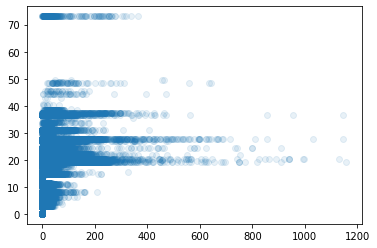

In [30]:
plt.plot(y_test, y_pred, 'o', alpha=0.1)

In [31]:
model_gs.score(X_test, y_test)

0.0659975224421977

## Save model and check reload

In [30]:
import pickle

In [33]:
with open('../model_data/random_forest_'+VERSION+'.pk', 'wb') as p:
    pickle.dump(model_gs, p)

In [35]:
%%time
with open('../model_data/random_forest_'+VERSION+'.pk', 'rb') as pp:
    loaded_model = pickle.load(pp)

CPU times: user 242 ms, sys: 537 ms, total: 780 ms
Wall time: 779 ms


In [38]:
with open('../model_data/test_feature_'+VERSION+'.pk', 'wb') as ptf:
    pickle.dump(X_test, ptf)

In [39]:
with open('../model_data/test_feature_'+VERSION+'.pk', 'rb') as ptfl:
    loaded_test_feature = pickle.load(ptfl)

In [40]:
with open('../model_data/test_target_'+VERSION+'.pk', 'wb') as ptg:
    pickle.dump(y_test, ptg)

In [41]:
with open('../model_data/test_target_'+VERSION+'.pk', 'rb') as ptgl:
    loaded_test_target = pickle.load(ptgl)

In [42]:
loaded_model.score(loaded_test_feature, loaded_test_target)

0.6611033661523691